# DecisionTree (의사결정나무)

In [102]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import  matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False
plt.style.use("ggplot")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")
sns.set_theme(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import load_iris,load_breast_cancer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, plot_roc_curve

In [67]:
# 여러 분류 지표 출력
def get_clf_eval(y_test,pred):
    cf = confusion_matrix(y_test,pred)
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred)
    rec = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    
    print(cf)
    print('정확도 :{0:.4f}, 정밀도 :{1:.4f}, 재현율 :{2:.4f}, F1 :{3:.4f}'.format(acc,pre,rec,f1))
#   return [acc, pre, rec, f1]

# 다중 분류 지표 출력
def get_multiclf_eval(y_test,pred):
    cf = confusion_matrix(y_test,pred)
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred, average='micro')
    rec = recall_score(y_test,pred, average='macro')
    f1 = f1_score(y_test,pred, average='weighted')
    
    print(cf)
    print('정확도 :{0:.4f}, 정밀도 :{1:.4f}, 재현율 :{2:.4f}, F1 :{3:.4f}'.format(acc,pre,rec,f1))
#   return [acc, pre, rec, f1]

# roc curve
def roc_curve_plot(y_test, pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba)
    
    plt.figure(figsize=(8,6))
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1],[0,1],linestyle='--', color='k', label='Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1 - Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()

### 의사결정나무 분류기

In [68]:
# 데이터 불러오기
iris= load_iris()
iris_df = pd.DataFrame(iris.data, columns=[word[:12].strip() for word in iris.feature_names])
print('iris_df.shape :',iris_df.shape)
iris_df.head()

iris_df.shape : (150, 4)


,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


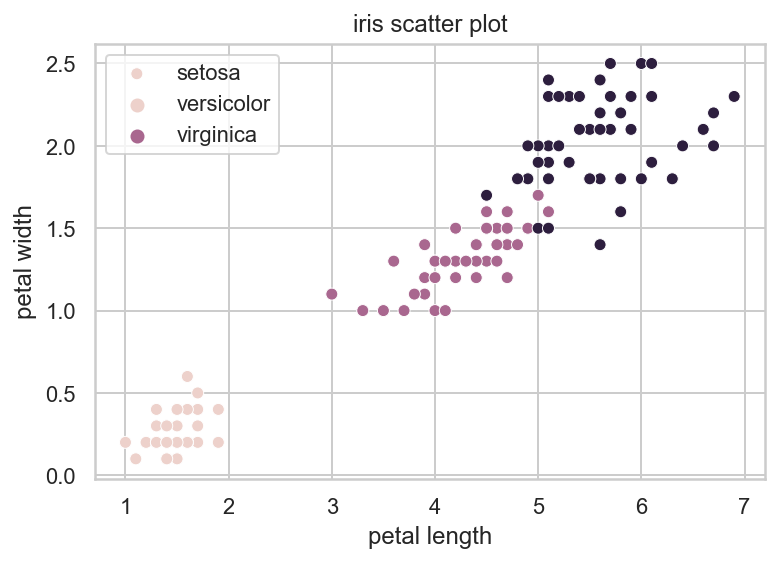

In [100]:
plt.title('iris scatter plot')
sns.scatterplot(iris_df.iloc[:,2],iris_df.iloc[:,3],hue=iris.target)
plt.legend(iris.target_names)
plt.show()

### 데이터 전처리

In [69]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2)

### 모델 학습

In [77]:
# 의사결정나무 분류기 학습
dt_clf = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 1, criterion='gini', max_features = 0.9)
dt_clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3, max_features=0.9)

In [101]:
dt_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 0.9,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [78]:
# 특성별 회귀 계수
print(dt_clf.feature_importances_)

[0.         0.         0.40278404 0.59721596]


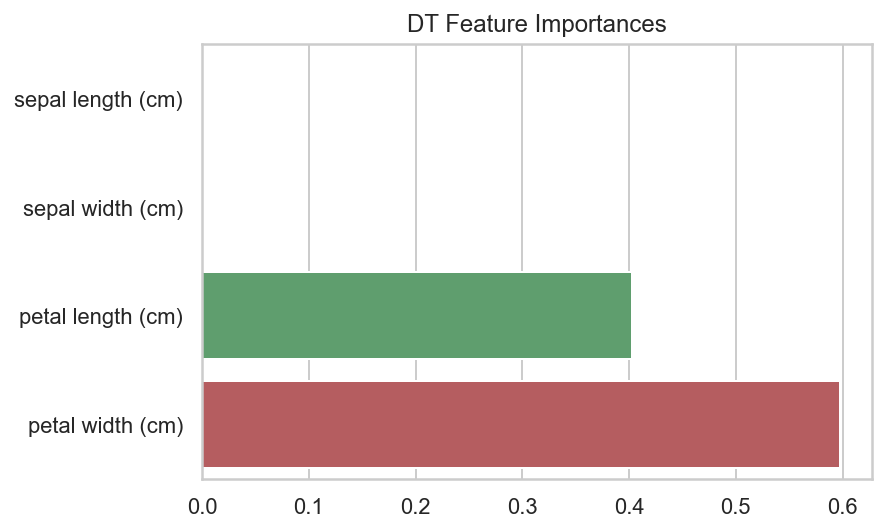

In [82]:
# 피처의 중요도 시각화 하기
plt.title('DT Feature Importances')
sns.barplot(x = dt_clf.feature_importances_, y = iris.feature_names)
plt.show()

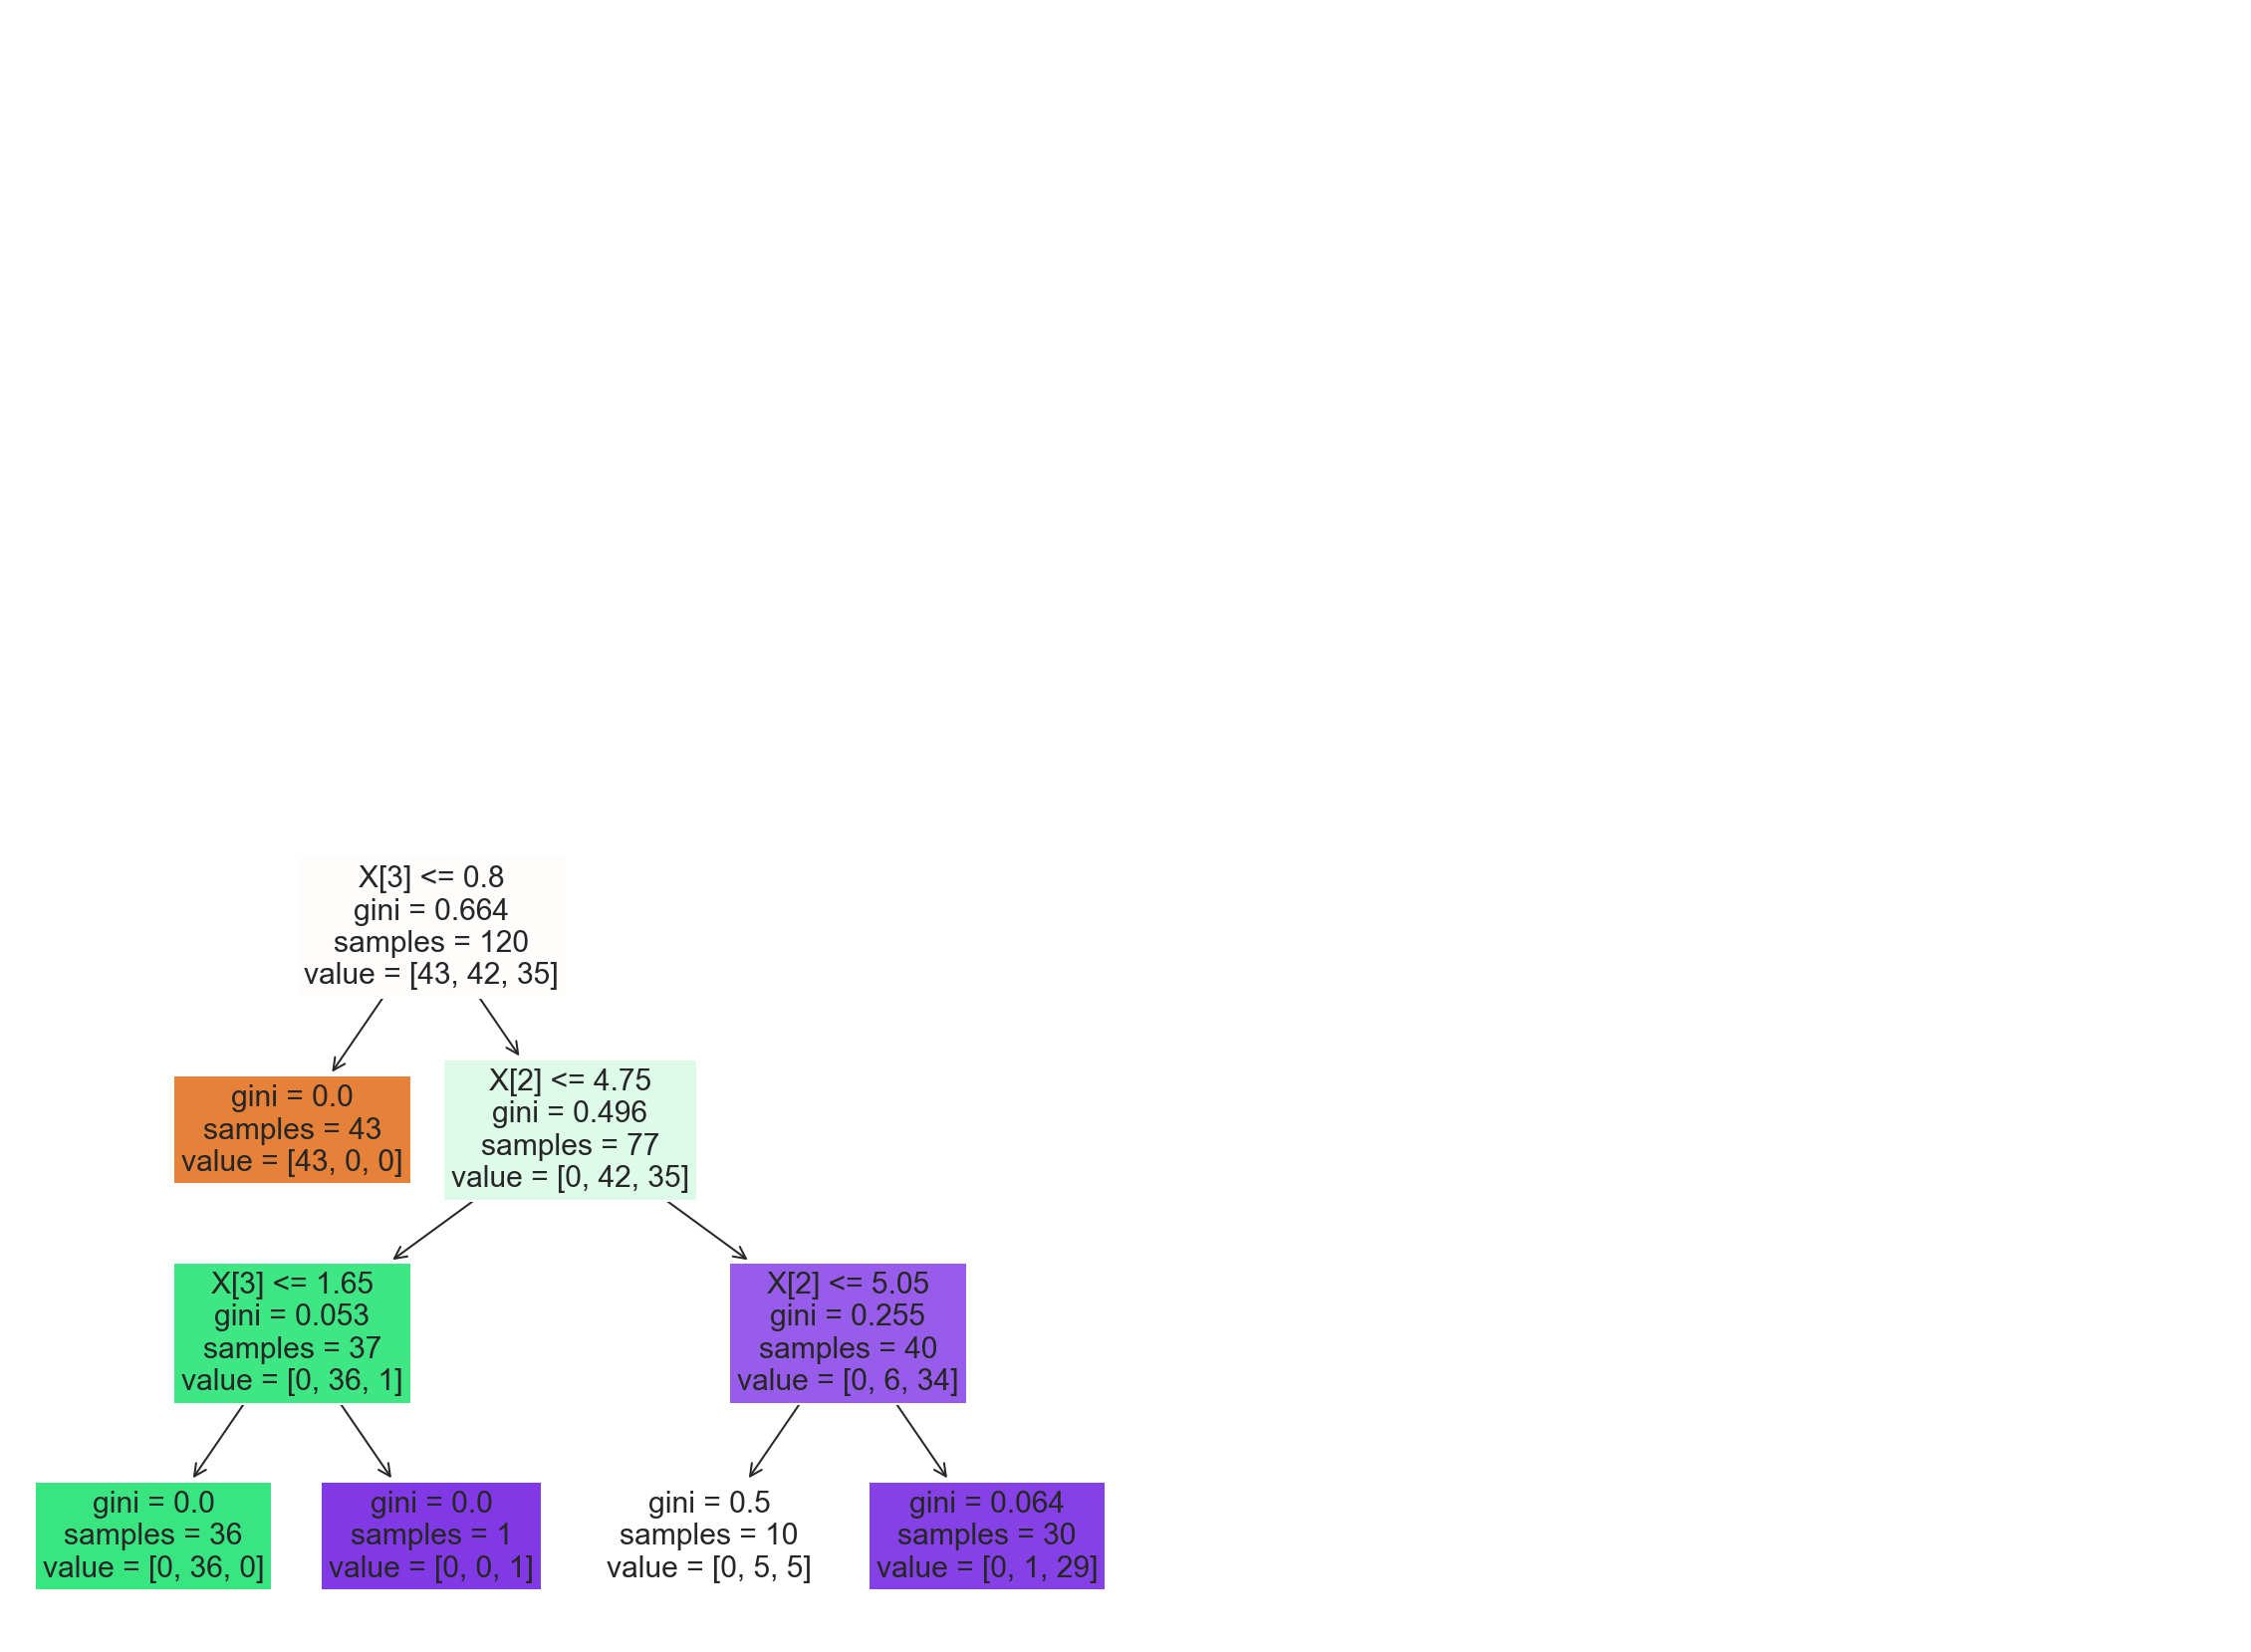

In [90]:
# 의사결정나무 시각화
fig = plt.figure(figsize=(20,15))
plot_tree(dt_clf, filled=True, fontsize=15)
plt.show()

In [91]:
# 의사결정 규칙 출력
print(export_text(dt_clf, feature_names = iris_df.columns.tolist()))

|--- petal width <= 0.80
|   |--- class: 0
|--- petal width >  0.80
|   |--- petal length <= 4.75
|   |   |--- petal width <= 1.65
|   |   |   |--- class: 1
|   |   |--- petal width >  1.65
|   |   |   |--- class: 2
|   |--- petal length >  4.75
|   |   |--- petal length <= 5.05
|   |   |   |--- class: 1
|   |   |--- petal length >  5.05
|   |   |   |--- class: 2



### 모델 평가

In [85]:
# 의사결정나무 모델 평가
pred = dt_clf.predict(X_test)
get_multiclf_eval(y_test,pred)

[[ 7  0  0]
 [ 0  8  0]
 [ 0  3 12]]
정확도 :0.9000, 정밀도 :0.9000, 재현율 :0.9333, F1 :0.9023


### 하이퍼파라미터 튜닝

In [70]:
dt_clf = DecisionTreeClassifier()

param_grid = {'max_depth':[2,3,4,5],
              'min_samples_leaf':[1,5,10,20,30]}

dt_grid = GridSearchCV(dt_clf, param_grid=param_grid, cv=3, refit=True)
dt_grid.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [1, 5, 10, 20, 30]})

In [71]:
score_df = pd.DataFrame(dt_grid.cv_results_)
score_df[['params','mean_test_score','rank_test_score','split0_test_score']].sort_values('rank_test_score').head()

,params,mean_test_score,rank_test_score,split0_test_score
5,"{'max_depth': 3, 'min_samples_leaf': 1}",0.925000,1,0.95
6,"{'max_depth': 3, 'min_samples_leaf': 5}",0.916667,2,0.95
10,"{'max_depth': 4, 'min_samples_leaf': 1}",0.916667,2,0.95
11,"{'max_depth': 4, 'min_samples_leaf': 5}",0.916667,2,0.95
16,"{'max_depth': 5, 'min_samples_leaf': 5}",0.916667,2,0.95


In [72]:
print(dt_grid.best_params_)
print(dt_grid.best_score_)

{'max_depth': 3, 'min_samples_leaf': 1}
0.9249999999999999


In [73]:
best = dt_grid.best_estimator_
pred = best.predict(X_test)

In [74]:
get_multiclf_eval(y_test,pred)

[[ 7  0  0]
 [ 0  8  0]
 [ 0  1 14]]
정확도 :0.9667, 정밀도 :0.9667, 재현율 :0.9778, F1 :0.9671


In [75]:
best.feature_importances_

array([0.        , 0.        , 0.05930452, 0.94069548])

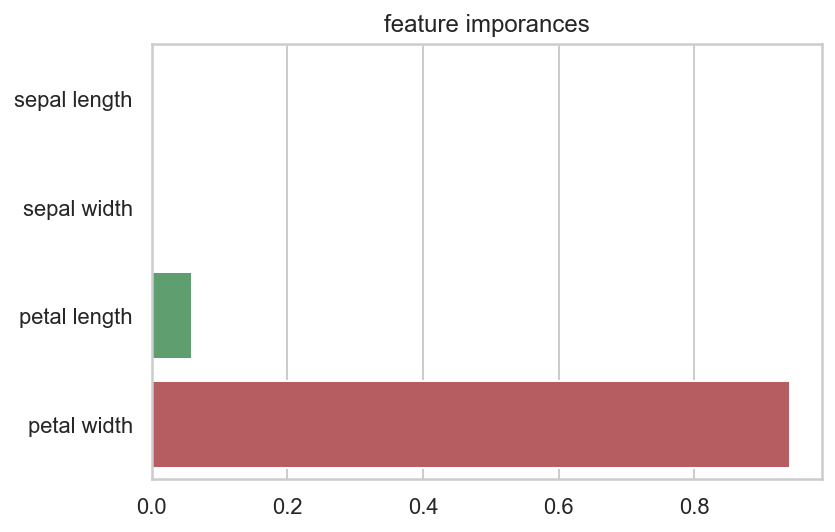

In [76]:
plt.title('feature imporances')
sns.barplot(x = best.feature_importances_, y = iris_df.columns.tolist())
plt.show()

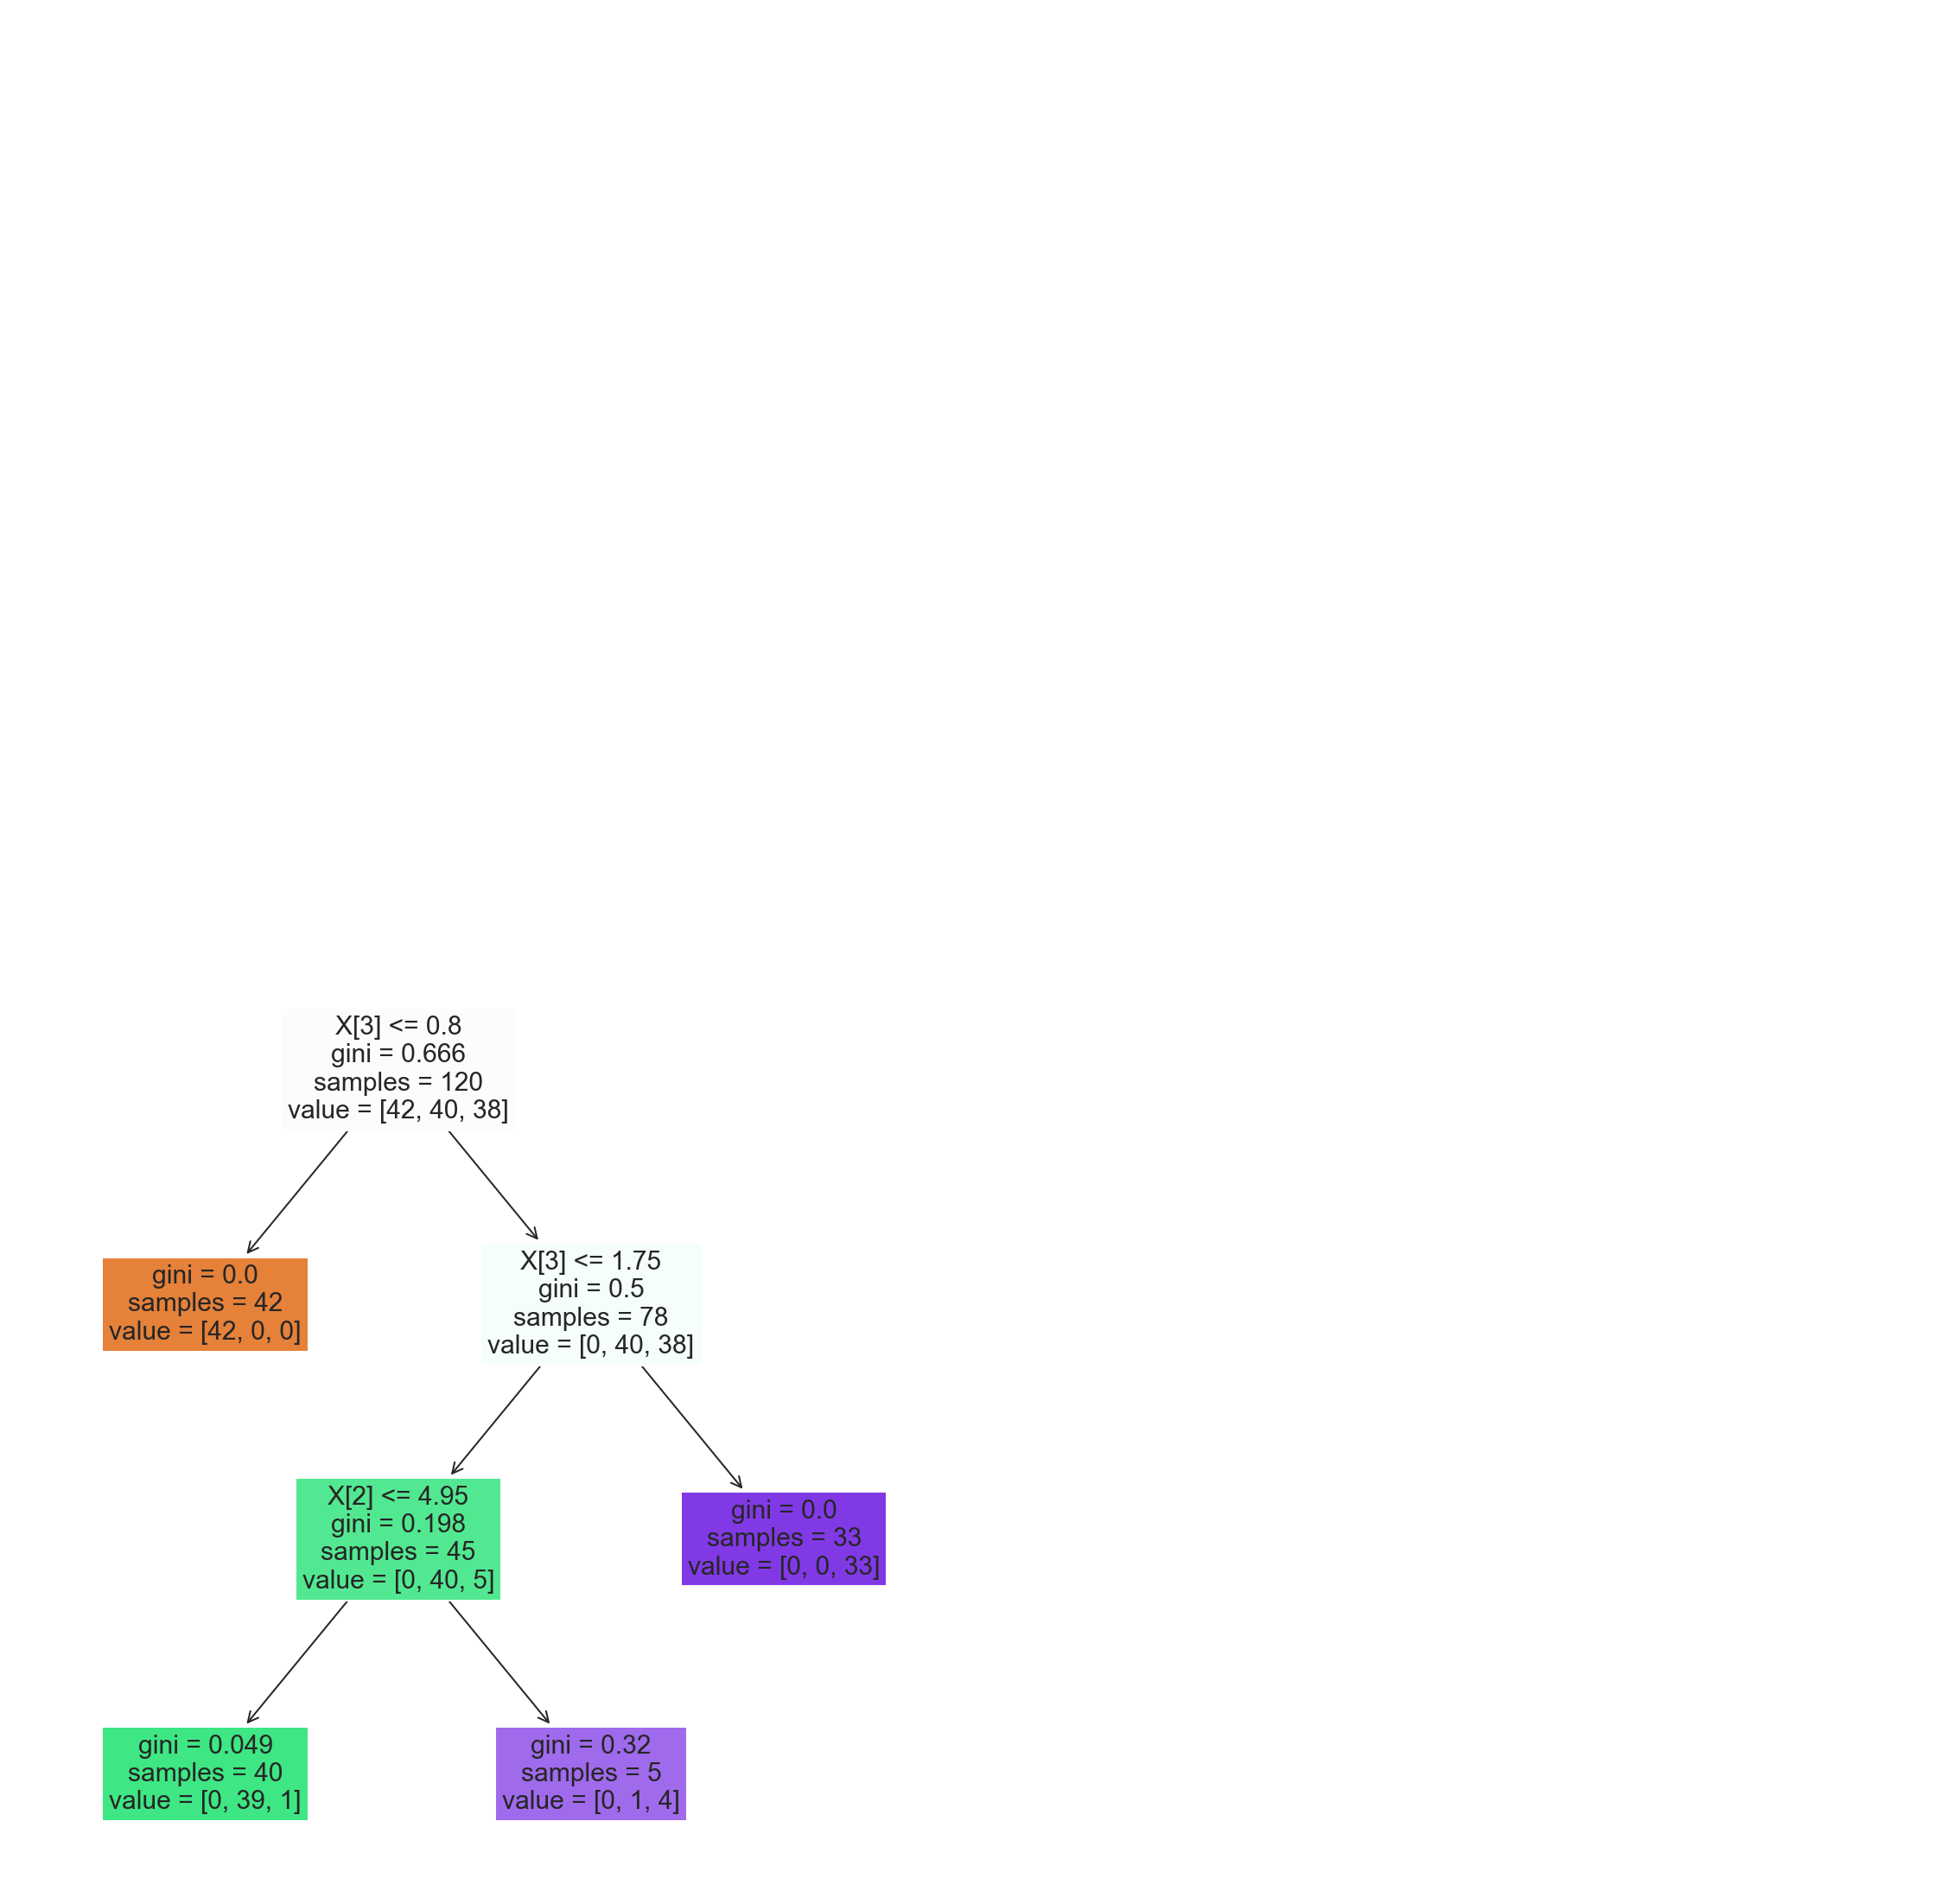

In [65]:
fig = plt.figure(figsize=(20,20))
plot_tree(best, filled=True, fontsize=15)
plt.show()

In [66]:
print(export_text(best, feature_names = iris_df.columns.tolist()))

|--- petal width <= 0.80
|   |--- class: 0
|--- petal width >  0.80
|   |--- petal width <= 1.75
|   |   |--- petal length <= 4.95
|   |   |   |--- class: 1
|   |   |--- petal length >  4.95
|   |   |   |--- class: 2
|   |--- petal width >  1.75
|   |   |--- class: 2

